[Class08:LangGraph: External Memory with External DB, Introduction to Agentic RAG - 23 Nov 2024](https://www.youtube.com/watch?v=ooU238RcOdo&list=PL0vKVrkG4hWoHDg46N85-9NDhmOaPWEwA&index=9)


**Module 2 :** 6.0_chatbot_external_memory,

**rm note**

**Without Persistent State, data is lost when the application is disconnected.**

Thread_id is lost when it is disconnect.

**`checkpointer=memory`**

Checkpoints are Saved in a thread:

Threads act as memory locations where the state is saved.

Through the thread_id, the state is saved into the memory location.

Now we use Sqlite to save data

**In memory**

```bash
import sqlite3
conn = sqlite3.connect(":memory:", check_same_thread = False)
```

**Here is our checkpointer**

```base
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)
```

**pass (checkpoint=memory) into the graph**

```bash
builder: StateGraph = StateGraph(State)
graph: CompiledStateGraph = builder.compile(checkpointer=memory)
```

**graph_state() : return snapshort**

Let's confirm that our state is saved locally.

```bash
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state
```
**Note:- When we compile the graph, the messages can be seen at the start, before invoke**

**reason :** The data is retrieved at the starting point before invoking messages because the script, during the initialization of the database, already contains some data in script.

**problem**

When data doesn't have a persistent state, it gets lost when the application is disconnected.

Note: The data file example.db in the state_db folder is missing, and the folder itself is also lost.

**old method**

**MemorySaver**, an in-memory key-value store for Graph state

**MemorySaver retains the state while connected**. Once disconnected, the data is lost

**`memory: MemorySaver = MemorySaver()`**

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_google_genai

In [2]:
# API Keys
# Get the GEMINI API key from user data
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

In [4]:
import os
%env LANGCHAIN_API_KEY = {userdata.get('LANGCHAIN_API_KEY')}
#%env GOOGLE_API_KEY = {userdata.get('GEMINI_API_KEY')} # it print api key

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

env: LANGCHAIN_API_KEY=LangSmith is a standalone platform for building, monitoring, and evaluating production-grade LLM applications, ensuring quick and confident deployments.


## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database.

If we supply `":memory:"` it creates an in-memory Sqlite database.

In [8]:
# create sqlite3 database to store data
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [9]:
# creating file and store data into it
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2024-12-05 09:55:37--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2024-12-05 09:55:37--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.004s  

2024-12-05 09:55:37 (24.4 MB/s) - ‘s

In [10]:
# pass Sqlite in checkerpointer
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

Let's re-define our chatbot.

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

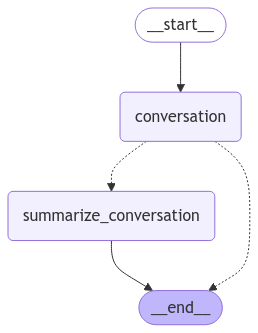

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
# here checkpointer=memory has Sqlite (external memory)
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [16]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# two messages first human message and ai message but print only ai messages (output)
# all messages save inot thread_id 1

# Start conversation

print("1 message")
input_message = HumanMessage(content="hi! I'm Raheela")
print("1 input_message")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

print("2 message")
input_message = HumanMessage(content="what's my name?")
print("2 input_message")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

print("3 message")
input_message = HumanMessage(content="i like the 49ers!")
print("3 input_message")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

1 message
1 input_message


================================== Ai Message ==================================

Hi Raheela!  It's good to chat with you again.  What's on your mind today?
2 message
2 input_message


================================== Ai Message ==================================

Your name is Raheela.
3 message
3 input_message
================================== Ai Message ==================================

That's great!  Are you looking forward to the upcoming season?  Do you have a favorite player?


Let's confirm that our state is saved locally.

In [13]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state # return snapshort

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='086e80ce-8bd0-4dee-b13c-f47160d6755f'), AIMessage(content="Hello Lance! You've already introduced yourself, but it's nice to greet you again. Is there something specific you'd like to talk about? Perhaps you'd like to continue our conversation about the 49ers, or is there another topic you're interested in discussing?", additional_kwargs={}, response_metadata={'id': 'msg_01AkDF6AH7LMp2YDDD9jQkEC', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 197, 'output_tokens': 58}}, id='run-7f8af5e1-5248-4ccd-ab46-87580422f0d6-0', usage_metadata={'input_tokens': 197, 'output_tokens': 58, 'total_tokens': 255}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='e33f42ee-cdb0-45ec-b100-54dcd4c82e71'), AIMessage(content="Your name is Lance. You've introduced yourself twice durin

### Persisting state

Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [14]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='086e80ce-8bd0-4dee-b13c-f47160d6755f'), AIMessage(content="Hello Lance! You've already introduced yourself, but it's nice to greet you again. Is there something specific you'd like to talk about? Perhaps you'd like to continue our conversation about the 49ers, or is there another topic you're interested in discussing?", additional_kwargs={}, response_metadata={'id': 'msg_01AkDF6AH7LMp2YDDD9jQkEC', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 197, 'output_tokens': 58}}, id='run-7f8af5e1-5248-4ccd-ab46-87580422f0d6-0', usage_metadata={'input_tokens': 197, 'output_tokens': 58, 'total_tokens': 255}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='e33f42ee-cdb0-45ec-b100-54dcd4c82e71'), AIMessage(content="Your name is Lance. You've introduced yourself twice durin

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Now that we better understand external memory, recall that the LangGraph API packages your code and provides you with with built-in persistence.

And the API is the back-end for Studio!

Load the `chatbot` in the UI, which uses `module2-/studio/chatbot.py` set in `module2-/studio/langgraph.json`.